In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
print("Set completed")

Set completed


In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print(f"train_data shape: {train_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (1460, 81)
test_data shape: (1459, 80)


In [5]:
print("train data info")
print(train_data.info())

train data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64

In [12]:
print(train_data['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [13]:
train_data['SalePrice'].skew()


np.float64(1.8828757597682129)

Text(0, 0.5, 'Frequency')

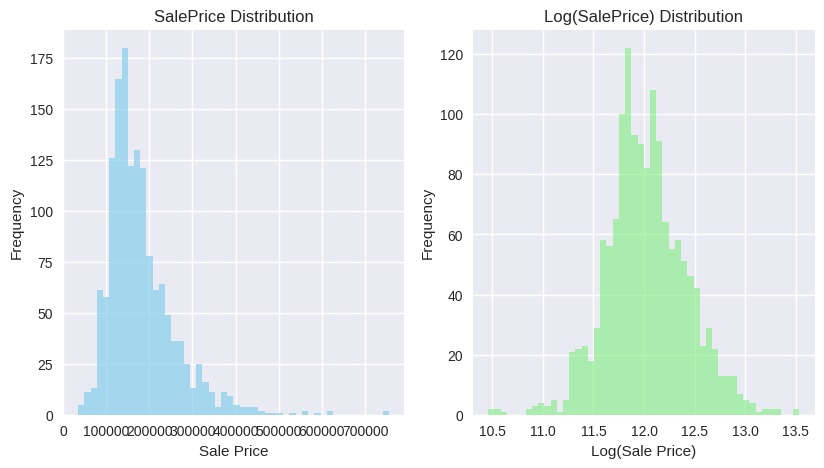

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(train_data['SalePrice'],bins=50,alpha=0.7,color='skyblue');
plt.title('SalePrice Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')


plt.subplot(1,3,2)
plt.hist(np.log1p(train_data['SalePrice']),bins=50,alpha=0.7,color='lightgreen')
plt.title('Log(SalePrice) Distribution')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency');


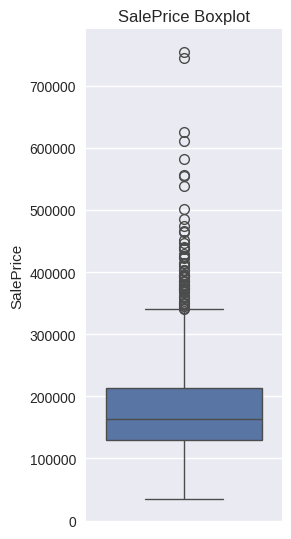

In [16]:
plt.subplot(1, 3, 3)
sns.boxplot(y=train_data['SalePrice'])
plt.title('SalePrice Boxplot')
plt.tight_layout()
plt.show()

In [7]:
missing_train = train_data.isnull().sum().sort_values(ascending=False)
missing_test = test_data.isnull().sum().sort_values(ascending=False)

In [8]:
print("top 20 thieu o train data")
print(missing_train[missing_train>0].head(20))


top 20 thieu o train data
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [9]:
print("top 20 thieu o test data")
print(missing_test[missing_test>0].head(20))

top 20 thieu o test data
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64


In [13]:
train_ids=train_data['Id']
test_ids=test_data['Id']

X_train = train_data.drop(['Id','SalePrice'],axis=1)
y_train = train_data['SalePrice']

X_test=test_data.drop('Id',axis=1)

all_data=pd.concat([X_train,X_test],axis=0)
print(f"all data shape : {all_data.shape}")

all data shape : (2919, 79)


In [14]:
def handle_missing_values(df):
    data=df.copy()
    none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'MasVnrType']
    for col in none_cols:
        if col in data.columns:
            data[col]=data[col].fillna('None')

    numeric_cols=data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        data[col]=data[col].fillna(data[col].median())

    categorical_cols=data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        data[col]=data[col].fillna(data[col].mode()[0] if len(data[col].mode())>0 else 'Unknown')
    return data

all_data_clean=handle_missing_values(all_data)

print(all_data_clean.isnull().sum().sum())

0


In [15]:
def creature_new_features(df):
    data=df.copy()
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalBath'] = data['FullBath'] + 0.5 * data['HalfBath'] + data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']
    data['TotalPorch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
    data['Age'] = data['YrSold'] - data['YearBuilt']
    data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
    data['IsNew'] = (data['YrSold'] - data['YearBuilt'] <= 1).astype(int)
    data['OverallGrade'] = data['OverallQual'] * data['OverallCond']
    data['KitchenScore'] = data['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}) * data['KitchenAbvGr']
    

    data['TotalArea'] = data['GrLivArea'] + data['TotalBsmtSF']
    data['BathPerRoom'] = data['TotalBath'] / (data['TotRmsAbvGrd'] + 1)
    data['RoomDensity'] = data['TotRmsAbvGrd'] / (data['GrLivArea'] + 1)
    

    data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch'] + data['WoodDeckSF']
    data['HasPool'] = (data['PoolArea'] > 0).astype(int)
    data['Has2ndFloor'] = (data['2ndFlrSF'] > 0).astype(int)
    data['HasGarage'] = (data['GarageArea'] > 0).astype(int)
    data['HasFireplace'] = (data['Fireplaces'] > 0).astype(int)
    data['HasBsmt'] = (data['TotalBsmtSF'] > 0).astype(int)
   
    data['LuxuryHome'] = (
        (data['GrLivArea'] > 3500) | (data['OverallQual'] >= 9) |
        (data['GarageCars'] >= 3) | (data['TotalBsmtSF'] > 1500) |
        (data['PoolArea'] > 0) | (data['LotArea'] > 15000)
    ).astype(int)
    

    new_features = ['BathPerRoom', 'RoomDensity', 'LuxuryHome']
    for feature in new_features:
        if feature in data.columns:
            data[feature] = data[feature].fillna(0)
    
    return data

all_data_featured=creature_new_features(all_data_clean)

In [22]:
from xgboost import XGBRegressor
neigh_median = train_data.groupby('Neighborhood')['SalePrice'].median()
all_data_featured['Neighborhood_Price'] = all_data_featured['Neighborhood'].map(neigh_median)

# Label encode các cột còn lại
for col in all_data_featured.select_dtypes(include='object').columns:
    le = LabelEncoder()
    all_data_featured[col] = le.fit_transform(all_data_featured[col].astype(str))

# Tách lại train/test sau khi thêm feature
X_train_final = all_data_featured.iloc[:len(train_data), :]
X_test_final = all_data_featured.iloc[len(train_data):, :]
y_train_log = np.log1p(train_data['SalePrice'])

print(f"Train shape: {X_train_final.shape}")
print(f"Test shape : {X_test_final.shape}")

# === Thiết lập model XGBoost mạnh ===
xgb_model = XGBRegressor(
    n_estimators=2500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=0.8,
    random_state=42,
    n_jobs=-1
)

# === 5-Fold Cross Validation ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
oof_preds = np.zeros(len(X_train_final))
test_preds = np.zeros(len(X_test_final))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_final)):
    print(f"\n===== Fold {fold+1} =====")
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)


    val_pred = xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

    oof_preds[val_idx] = val_pred
    test_preds += xgb_model.predict(X_test_final) / kf.n_splits

print("\n===== Kết quả trung bình =====")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

# === Xuất file submission ===
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': np.expm1(test_preds)  # đảo log
})
submission.to_csv('submission_xgb_advanced.csv', index=False)
print("✅ File 'submission_xgb_advanced.csv' đã được tạo.")

Train shape: (1460, 98)
Test shape : (1459, 98)

===== Fold 1 =====
Fold 1 RMSE: 0.1324

===== Fold 2 =====
Fold 2 RMSE: 0.1097

===== Fold 3 =====
Fold 3 RMSE: 0.1627

===== Fold 4 =====
Fold 4 RMSE: 0.1187

===== Fold 5 =====
Fold 5 RMSE: 0.1081

===== Kết quả trung bình =====
Average RMSE: 0.1263 ± 0.0202
✅ File 'submission_xgb_advanced.csv' đã được tạo.


In [29]:
def encode_categorical(df):
    data = df.copy()
    categorical_cols = data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col in data.columns:
            le = LabelEncoder()
            try:
                data[col] = le.fit_transform(data[col].astype(str))
            except:
                data[col] = data[col].astype('category').cat.codes
    
    return data

all_data_encoded = encode_categorical(all_data_featured)

In [30]:
X_train_processed = all_data_encoded.iloc[:len(X_train), :]
X_test_processed = all_data_encoded.iloc[len(X_train):, :]

print(f"train_processed ve lai ban dau: {X_train_processed.shape}")
print(f"test_processed ve lai ban dau: {X_test_processed.shape}")

train_processed ve lai ban dau: (1460, 97)
test_processed ve lai ban dau: (1459, 97)


In [32]:
print(f"X_train_processed NaN {X_train_processed.isnull().sum().sum()}")
print(f"X_test_processed NaN: {X_test_processed.isnull().sum().sum()}")

X_train_processed NaN 0
X_test_processed NaN: 0


In [33]:
X_train_selected = X_train_processed
X_test_selected = X_test_processed
print(f"使用所有特征进行训练，特征数量: {X_train_selected.shape[1]}")

使用所有特征进行训练，特征数量: 97


In [35]:
y_train_log = np.log1p(y_train)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_selected, y_train_log, test_size=0.2, random_state=42
)

In [38]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=700, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        
        max_features='sqrt'   
    ),
    'Lasso': Lasso(alpha=0.0005, random_state=42, max_iter=2000),  
    'Ridge': Ridge(alpha=10.0, random_state=42)  
}

results = {}
for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")
best_model_name = min(results, key=results.get)
print(f"\nbest_model: {best_model_name}")

RandomForest RMSE: 0.1457
GradientBoosting RMSE: 0.1315
Lasso RMSE: 0.1522
Ridge RMSE: 0.1526

best_model: GradientBoosting


In [39]:
if best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(n_estimators=700, random_state=42)
elif best_model_name == 'GradientBoosting': best_model = GradientBoostingRegressor(
   n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        # 增加子采样
        max_features='sqrt'   
)
elif best_model_name == 'Lasso':
    best_model = Lasso(alpha=0.0005, random_state=42, max_iter=2000)
else:
    best_model = Ridge(alpha=10.0, random_state=42)

best_model.fit(X_train_selected, y_train_log)

print("\n开始集成学习...")


开始集成学习...


In [44]:
#ensemble
models_to_ensemble = {
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        # 增加子采样
        max_features='sqrt'   
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=300,  # 减少树数量以加快训练
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ),
    'Lasso': Lasso(alpha=0.0005, random_state=42, max_iter=2000)  # 调整alpha
}


ensemble_predictions_val = {}
ensemble_models = {}

for name, model in models_to_ensemble.items():
    print(f"Mo hinh: {name}")
    model.fit(X_tr, y_tr)
    ensemble_models[name] = model
    y_pred_val = model.predict(X_val)
    ensemble_predictions_val[name] = y_pred_val
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print(f"{name} RMSE : {rmse:.4f}")


Mo hinh: GradientBoosting
GradientBoosting RMSE : 0.1315
Mo hinh: RandomForest
RandomForest RMSE : 0.1489
Mo hinh: Lasso
Lasso RMSE : 0.1522


In [41]:
weights = {}
for name, pred in ensemble_predictions_val.items():
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    weights[name] = 1 / (rmse + 1e-6)  

total_weight = sum(weights.values())
for name in weights:
    weights[name] /= total_weight

print("\n模型权重:")
for name, weight in weights.items():
    print(f"{name}: {weight:.4f}")

ensemble_val_pred = np.zeros_like(y_val)
for name, pred in ensemble_predictions_val.items():
    ensemble_val_pred += weights[name] * pred

ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred))
print(f"集成模型验证集RMSE: {ensemble_rmse:.4f}")

if ensemble_rmse < results[best_model_name]:
    print("集成模型表现更好，使用集成模型")
    
    for name, model in models_to_ensemble.items():
        print(f"在整个训练集上重新训练: {name}")
        model.fit(X_train_selected, y_train_log)
        ensemble_models[name] = model
    
    test_predictions_log = np.zeros(X_test_selected.shape[0])
    for name, model in ensemble_models.items():
        pred = model.predict(X_test_selected)
        test_predictions_log += weights[name] * pred
    
else:
    print("最佳单个模型表现更好，使用最佳单个模型")


模型权重:
GradientBoosting: 0.3640
RandomForest: 0.3215
Lasso: 0.3145
集成模型验证集RMSE: 0.1361
最佳单个模型表现更好，使用最佳单个模型


In [43]:
def smart_post_process(predictions, y_train):
    """
    智能后处理：基于训练集分布调整预测值
    """
    predictions_clean = predictions.copy()
    
    train_q1 = np.percentile(y_train, 25)
    train_q3 = np.percentile(y_train, 75)
    train_iqr = train_q3 - train_q1
    lower_bound = train_q1 - 1.5 * train_iqr
    upper_bound = train_q3 + 1.5 * train_iqr
    
    predictions_clean = np.clip(predictions_clean, lower_bound, upper_bound)
    predictions_clean = np.round(predictions_clean / 100) * 100
    
    print(f"后处理范围: [{lower_bound:.0f}, {upper_bound:.0f}]")
    print(f"后处理前统计: 均值={predictions.mean():.0f}, 标准差={predictions.std():.0f}")
    print(f"后处理后统计: 均值={predictions_clean.mean():.0f}, 标准差={predictions_clean.std():.0f}")
    
    return predictions_clean

In [ ]:
test_predictions_log = best_model.predict(X_test_selected)
test_predictions = np.expm1(test_predictions_log)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})
submission.to_csv('submission.csv', index=False)